<a href="https://colab.research.google.com/github/mcroning/Nonlinear-Beam-Propagation/blob/main/PRcoupler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PR coupler allowing time dependent modelling at sample grid 4096x1024x800 xyz steps (usually 1000 x 500 x 4000 um) Two copies of the full photorefractive grating must be stored in xyz, leading to the need to batch into CPU memory using A100 GPU (83GB CPU, 40GB GPU) The arrays occupy 27GB each in this case.

In [1]:
import sys
import cupy as cp
from cupyx.scipy.ndimage import zoom, gaussian_filter
from scipy.ndimage import gaussian_filter as gaussian_filter_cpu
from scipy.ndimage import zoom as zoom_cpu
from scipy.special import erf
import cupyx.scipy.fft as spfft
from cupy import NaN
import time
import os
from os.path import exists
import numpy as np
import random
from imageio.v2 import imread
from scipy.io import savemat,loadmat
from scipy import signal
from scipy.stats import expon
from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from PIL import Image, ImageChops
from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from tqdm import tqdm
import gc

In [2]:
# @title  Connect to Github for sample images
if not os.path.exists("/content/Nonlinear-Beam-Propagation"):
  !git clone https://github.com/mcroning/Nonlinear-Beam-Propagation

Cloning into 'Nonlinear-Beam-Propagation'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 300 (delta 95), reused 126 (delta 55), pack-reused 99
Receiving objects: 100% (300/300), 39.84 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [36]:

# @title Set Parameters { run: "auto" }
gain_length_product = -3 # @param {type:"number"}
intensity_beam_ratio_2_to_1 = 6.67 # @param {type:"number"}
image_on_beam = "No Image" # @param ["No Image","Beam 1","Beam 2","Beams 1 & 2"]
image_type = "real image" # @param ["real image", "phase image"]
image_size_norm_by_waist1 = 1 # @param {type:"number"}
image_file_name = "" # @param {type:"string"}
std_image = "AF Res Chart" # @param ["MNIST 0", "MNIST 1", "MNIST 2", "MNIST 3", "MNIST 4", "MNIST 5", "MNIST 6", "MNIST 7", "MNIST 8", "MNIST 9", "AF Res Chart"]
image_invert = False # @param {type:"boolean"}
scattering_noise_type = "none" # @param ["none", "surface","volume xy","volume xyz"]
scattering_correlation_length_um = 0.6 # @param {type:"number"}
volume_noise_amplitude_per_mm = 0.02 # @param {type:"number"}
kerr_coeff = 0 # @param {type:"number"}
surface_noise_amplitude = 0.1 # @param {type:"number"}
x_aperture_um = 1000 # @param {type:"number"}
y_aperture_um = 1000 # @param {type:"number"}
x_samples = "2048" # @param ["1024", "2048", "4096", "8192", "16384","32768"]
y_samples = "512" # @param ["256", "512", "1024", "2048"]
interaction_length_um = 4000 # @param {type:"number"}
z_step_um = 10 # @param {type:"number"}
wavelength_um = 0.625 # @param {type:"number"}
beam_waist_1 = 100 # @param {type:"number"}
beam_waist_2 = 100 # @param {type:"number"}
external_angle_beam_1 = 0.16 # @param {type:"number"}
external_angle_beam_2 = -0.16 # @param {type:"number"}
azimuth_1 = 0 # @param {type:"number"}
azimuth_2 = 0 # @param {type:"number"}
prop_random_steps = False # @param {type:"boolean"}
backpropagate_output_image = False # @param {type:"boolean"}
time_behavior = "Time Dependent" # @param ["Static", "Time Dependent"]
number_of_time_steps = 24 # @param {type:"integer"}
end_time_t0 = 1.8 # @param {type:"number"}
batchnum_spec = 1 # @param {type:"number"}
batchnum_spec=int(batchnum_spec)
fanning_study = False # @param {type:"boolean"}
save_noise = False # @param {type:"boolean"}
use_old_noise = False # @param {type:"boolean"}
Google_drive_save_folder = "whole beam paper wide" # @param {type:"string"}
save_output = False # @param {type:"boolean"}
relative_dielectric_constant = 2500 # @param {type:"number"}
mobile_charge_density = 6.22e22 # @param {type:"number"}
temperature_K = 293 # @param {type:"number"}
refractive_index = 2.4 # @param {type:"number"}
dark_intensity = 0.01 # @param {type:"number"}
Tukey_window_edge = 0.1 # @param {type:"number"}
folder=Google_drive_save_folder
savedata=save_output
kt=kerr_coeff

warning = ""

prop_random=prop_random_steps
realimage=image_type=='real image'
refin=refractive_index
NT=mobile_charge_density
epsr=relative_dielectric_constant
T=temperature_K
Id=dark_intensity
gl=gain_length_product
sigma=scattering_correlation_length_um
noiseamp=volume_noise_amplitude_per_mm
surfacenoise=surface_noise_amplitude
tsteps=number_of_time_steps
tend=end_time_t0
xaper=x_aperture_um
yaper=y_aperture_um
xsamp=int(x_samples)
ysamp=int(y_samples)
rlen=interaction_length_um
dz=z_step_um
image_size_factor=image_size_norm_by_waist1
lm=wavelength_um
w01=beam_waist_1
w02=beam_waist_2
thout1=external_angle_beam_1
thout2=external_angle_beam_2
phi1=azimuth_1
phi2=azimuth_2
rat=intensity_beam_ratio_2_to_1
windowedge=Tukey_window_edge
transp2=image_on_beam==("Beam 2" or "Beams 1 & 2")
transp1=image_on_beam==("Beam 1" or "Beams 1 & 2")
noisetype=scattering_noise_type
backpropagate=backpropagate_output_image
timedep=time_behavior=="Time Dependent"
image_in=cp.ones((28,28),dtype=cp.uint8) #default image
q=1.602e-19
eps0=8.854e-12
kB=1.380649e-23
k0=q*cp.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
kout=2*cp.pi/lm      #external wavenumber
dirName=os.getcwd()
niter=int(rlen/dz)
batchsize=niter//batchnum_spec # number of xy planes in each batch
nbatches=niter//batchsize  #actual number of batches that will fut in niter dz steps
try:
  figimin.clear()
except:
  pass
if image_file_name == "":
  match std_image:
    case "MNIST 0":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist0.png"
    case "MNIST 1":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist1.png"
    case "MNIST 2":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist2.png"
    case "MNIST 3":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist3.png"
    case "MNIST 4":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist4.png"
    case "MNIST 5":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist5.png"
    case "MNIST 6":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist6.png"
    case "MNIST 7":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist7.png"
    case "MNIST 8":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist8.png"
    case "MNIST 9":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist9.png"
    case "AF Res Chart":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/AF Res Chart.png"
if (transp1==1 or transp2==1)  and os.path.exists(image_file_name):
  image_in = Image.open(image_file_name)
  if image_invert:
    image_in=ImageChops.invert(image_in)
  image_in = np.asarray(image_in)


  if np.ndim(image_in)==3: #color image to greyscale
      image_in=image_in.mean(axis=2)
  #image_in = image_in.T  # this transposition sets 1st coordinate to x and 2nd coordinate to y
  imsizex=np.shape(image_in)[0]  #find original x dimension of image
  imsizey=np.shape(image_in)[1]  #find original y dimension
  maxsize=max(imsizex,imsizey)   #find maximum side length, maxsizenormint

  if maxsize % 2 !=0: # make sure sidees are of even length
          maxsize +=1

  image_in_sq=np.ones((maxsize,maxsize))  # make square image matrix that will hold input omage
  image_in_sq[:imsizex,:imsizey]=image_in #load potentiallly non square image ont quare image matrix
  image_in=image_in_sq.astype(np.uint16) #No
  figimin = plt.figure(figsize=(5, 5), dpi=100)
  iminax=figimin.add_subplot()
  iminax.imshow(image_in,cmap='gray')
  iminax.set_title('input image')
  image_in = cp.asarray(image_in)
#central spatial freqiencies of input gaussians fx1,fx2,fy1,fy2
fx1=-np.cos(phi1)*np.sin(thout1)/lm
fy1=np.sin(phi1)*np.sin(thout1)/lm
fx2=-np.cos(phi2)*np.sin(thout2)/lm
fy2=np.sin(phi2)*np.sin(thout2)/lm
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2

w1 = widgets.Output(layout={'border': '1px solid black'})
w1.clear_output()
if not(-fxmax<fx1<fxmax and -fymax<fy1<fymax):
  with w1:
    print('Warning: Beam 1 spatial frequencies became outside grid limits')
if not(-fxmax<fx2<fxmax and -fymax<fy2<fymax):
   with w1:
    print('Warning: Beam 2 spatial frequencies became outside grid limits')
if xsamp*ysamp*rlen/dz > 8192*256*400*batchnum_spec and timedep:
  with w1:
    print('grid dimensions exceed V100 GPU capacity for time dependent calculation.' )
if xsamp*ysamp*rlen/dz > 4096*2048*4000/12.5*batchnum_spec and timedep:
  with w1:
    print('grid dimensions exceed A100 GPU capacity for time dependent calculation.' )
prdata={
    'gl': gl,
    'rat':rat,
    'image_on_beam':image_on_beam,
    'realimage':realimage,
    'image_size_factor':image_size_factor,
    'noisetype':noisetype,
    'sigma':sigma,
    'noiseamp': noiseamp,
    'kt':kt,
    'surfacenoise':surfacenoise,
    'xaper':xaper,
    'yaper':yaper,
    'xsamp':xsamp,
    'ysamp':ysamp,
    'rlen': rlen,
    'dz' : dz,
    'lm':lm,
    'w01':w01,
    'w02':w02,
    'thout1':thout1,
    'thout2':thout2,
    'phi1':phi2,
    'phi2':phi1,
    'prop_random':prop_random,
    'backpropagate':backpropagate,
    'timedep':timedep,
    'tsteps':tsteps,
    'tend':tend,
    'batchnum_spec':batchnum_spec,
    'epsr':epsr,
    'NT':NT,
    'T':T,
    'refin': refin,
    'Id':Id,
    'windowedge':windowedge,
    'transp1':transp1,
    'transp2':transp2
}
w1

Output(layout=Layout(border='1px solid black'))

In [37]:
# @title input amplitude generation functions
#ampxz: transverse amplitude cross section sampleed every fourth step (complex) [nsteps//4,xsamp,ysamp]
#resout: carries results for production version  (maybe needs only hold imout for deep learning)
#imout_final: square sample of output on beam 1 (positive frequencies) (currently size yaper/2)
#imin: input intensity matching imout_final
#gain: calculated coupling gain for two beam coupling
#ift: far field intensity (float) [nsteps,xsamp,ysamp]
#corrnoise: 3D noise array for optical scattering
#corrnoise1layer: 2D noise array for surface scattering
#prdata: dictionary containing variables and parameters
#pr_setup: tuple containing rotcoord rotated coordinates for beam angle, h optical propagator for uniform material, w Tukey window
def genrot(rlen,thout,phi,x,y):
  #generate coordinate frames rotated by input angles
  xs=len(x)
  ys=len(y)
  xp=cp.zeros((xs,ys))
  yp=cp.zeros((xs,ys))
  zp=cp.zeros((xs,ys))
  el=rlen/2.0 #interaction length
  th=cp.arcsin(cp.sin(thout)/refin)
  sP=cp.sin(phi)
  cP=cp.cos(phi)
  st=cp.sin(th)
  ct=cp.cos(th)
  s2p=2*sP*cP
  c2p=cP**2-sP**2
  xp=x[:,None]+cP*(1-ct)*(-x[:,None]*cP+y[None,:]*sP)-el*cP*st
  yp=y[None,:]+sP*(1-ct)*(x[:,None]*cP-y[None,:]*sP)+el*sP*st
  zp=(-el)*ct+(-x[:,None]*cP+y[None,:]*sP)*st
  return xp,yp,zp

def gaus(x,y,z,beam,arrin,prdata,w0x,w0y):
    #apply image to gaussian beam focussing at longitudinal center of crystal
    #x,y,z rotated coordinates, beam = beam number 1 or 2
    #w0x beam waist in x direction
    lm=prdata['lm']
    refin=prdata['refin']

    kin=refin*2*cp.pi/lm
    z0x=w0x**2*kin/2.0
    z0y=w0y**2*kin/2.0
    eta=(cp.arctan(z/z0x)+cp.arctan(z/z0y))/2
    #inverse radii of curvature
    rlxinv=z/(z**2+z0x**2)
    rlyinv=z/(z**2+z0y**2)
    #rlxinvmn=rlen/(rlen**2+z0x**2) #mean inverse radius of curvature
    wl2x=w0x**2*(1.0+(z/z0x)**2)
    wl2y=w0y**2*(1.0+(z/z0y)**2)
    wlxy=cp.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
    argx = (x**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
    argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
    arg=argx+argy
    # w0x<0 is a switch for plane wave input
    if w0x > 0:
      amp1 = cp.exp(-arg+1j*kin*z-1j*eta)/cp.sqrt(wlxy)
    else:
      amp1 = cp.exp(+1j*kin*z)

    if beam == 1:
      transp=prdata['transp1']
    else:
      transp=prdata['transp2']

    phasetransp=prdata['realimage']=="phase image"  #apply data as phase transparency if false
    # beam may have the data transparency imposed
    if transp:
      #find beam centers
      lenx,leny=cp.shape(arrin)
      xindex1,yindex1=getx0y0(x,y)

      if not phasetransp:
        amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2] \
          = arrin[:2*(lenx//2),:2*(leny//2)] \
          *amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2]
      else:
        amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2] \
          = cp.exp(1j*cp.pi*arrin[:2*(lenx//2),:2*(leny//2)]) \
          *amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2]

    return amp1

def a(arrin,prdata,rotcoord):
    rat=prdata['rat'] #beam ratio
    #a1r=1.0/cp.sqrt(1.0+rat)
    #a2r=cp.sqrt(rat)/cp.sqrt(1.0+rat)
    a1r=cp.sqrt(1.0/(1.0+rat))
    a2r=cp.sqrt(rat/(1.0+rat))

    xp1=rotcoord[0]
    yp1=rotcoord[1]
    zp1=rotcoord[2]
    xp2=rotcoord[3]
    yp2=rotcoord[4]
    zp2=rotcoord[5]
    # for the moment the beams have equal waists in x and y
    w0x1=prdata['w01']
    w0y1=prdata['w01']
    w0x2=prdata['w02']
    w0y2=prdata['w02']
    # generate beams 1 and 2
    amp1=gaus(xp1,yp1,zp1,1,arrin,prdata,w0x1,w0y1)
    amp2=gaus(xp2,yp2,zp2,2,arrin,prdata,w0x2,w0y2)
    # add them according to beam ratio
    atot=a1r*amp1+a2r*amp2
    return atot
def getx0y0(xp,yp):
  #find beam centers where xp and yp are zero
  x0,y0=cp.unravel_index(cp.argmin(xp1**2+yp1**2),(xsamp,ysamp))
  return (int(x0),int(y0))
def hidiff(ift,prdata):
  # routine to determine importance of artifact diffraction orders
  xsamp=prdata['xsamp'] ; ysamp=prdata['ysamp']
  xaper=prdata['xaper'] ; yaper=prdata['yaper']
  thout1=prdata['thout1'] ; thout2=prdata['thout2']
  phi1=prdata['phi1'] ; phi2=prdata['phi2']
  lm=prdata['lm']
  w01=prdata['w01']
  iwx=round(xaper/w01) ; iwy=round(yaper/w01)
  fx1=-np.cos(phi1)*np.sin(thout1)/lm
  fy1=np.sin(phi1)*np.sin(thout1)/lm
  fx2=-np.cos(phi2)*np.sin(thout2)/lm
  fy2=np.sin(phi2)*np.sin(thout2)/lm
  fx0=-xsamp/xaper/2 ; fy0=-ysamp/yaper/2
# p1,p2 indices of beam 1,2 in Fourier transform array
# p11,p21 indices of 1st higher order diff inbeam 1,2 in Fourier transform array
  p1=np.array((round((fx1-fx0)*xaper),round((fy1-fy0)*yaper)))
  p2=np.array((round((fx2-fx0)*xaper),round((fy2-fy0)*yaper)))
  p11=np.array((round((2*fx1-fx2-fx0)*xaper),round((2*fy1-fy2-fy0)*yaper)))
  p21=np.array((round((2*fx2-fx1-fx0)*xaper),round((2*fy2-fy1-fy0)*yaper)))
  s1=np.sum(ift[p1[0]+1-iwx:p1[0]+1+iwx,p1[1]+1-iwy:p1[1]+1+iwy])
  s11=np.sum(ift[p11[0]+1-iwx:p11[0]+1+iwx,p11[1]+1-iwy:p11[1]+1+iwy])
  s2=np.sum(ift[p2[0]+1-iwx:p2[0]+1+iwx,p2[1]+1-iwy:p2[1]+1+iwy])
  s21=np.sum(ift[p21[0]+1-iwx:p21[0]+1+iwx,p21[1]+1-iwy:p21[1]+1+iwy])
  hi_order_in_range_x= (iwx < p11[0] < (xsamp - iwx)) and (iwx < p21[0] < (xsamp - iwx))
  hi_order_in_range_y= (iwy < p11[1] < (ysamp - iwy)) and (iwy < p21[1] < (ysamp - iwy))

  #return fraction of artifact diffraction in output
  if hi_order_in_range_x and hi_order_in_range_y:
    return (s11+s21)/(s1+s2+s11+s21),p11,p1,p2,p21
  else:
    return -1,p11,p1,p2,p21

In [38]:
# @title Initialize arrays
# The input beams are two gaussian beams labeled beam 1 and beam 2
# which cross at the center of the crystal. Beam 1 generally
# travels with negative spatial frequency, when its angle is specified
# as positive.
# The input profiles of each beam are calculated using coodinate systems
# rotated about the center of the crytals by the internal polar and azimuthal
# propagation angles th1,phi1 and th2,phi2 (to account for
# refraction at the crystal surface). The field for beam 1 at crystal
# coordinate (x,y,z=0) is calculated using the corresponding coordinate
# (xp1,yp1,zp1) in the frame where the xp-yp plane is perpendicular to
# the direction of propagation of beam 1. This rotated coordinate is fed
# to the function gaus, defined below, which calculates a gaussian profile
# using the usual formula
# modelling frame coordinates (eg photorefractive crystal)
x=cp.linspace(-xaper/2,xaper/2*(1-2/xsamp),xsamp)
y=cp.linspace(-yaper/2,yaper/2*(1-2/ysamp),ysamp)
z=cp.linspace(0,rlen,niter)
rotcoord=cp.array((genrot(rlen,thout1,phi1,x,y),
                   genrot(rlen,thout2,phi2,x,y))).ravel()
rotcoord=cp.reshape(rotcoord,(6,xsamp,ysamp))

xp1=rotcoord[0]
xp2=rotcoord[3]
yp1=rotcoord[1]
yp2=rotcoord[4]

# provide masks in fourier plane to enable separation of beams 1 and 2
mask1=np.zeros((xsamp,ysamp))
Fyj=(np.arange(ysamp)-ysamp//2)/yaper
Fxk=(np.arange(xsamp)-xsamp//2)/xaper
DF1=(Fxk[:,None]-fx1)**2+(Fyj[None,:]-fy1)**2
DF2=(Fxk[:,None]-fx2)**2+(Fyj[None,:]-fy2)**2
mask1=np.where(DF1<=DF2,1,0)
mask1=cp.fft.fftshift(mask1)
mask1=cp.asarray(mask1)

# preprocess input image and generate input field

imsizex=cp.shape(image_in)[0]  #find original x dimension of image
imsizey=cp.shape(image_in)[1]  #find original y dimension
maxsize=max(imsizex,imsizey)   #find maximum side length, maxsize
if maxsize % 2 !=0: # make sure sides are of even length
     maxsize +=1
# if w01 is less than 0 it is the beam is set to be a plane wave.
# if w01>0 the image is scaled to the size factor times waist of beam 1
if prdata['w01'] > 0:
  # find zoom factor for image to place it on beam 1
  zoomsc=prdata['image_size_factor']*prdata['w01']/maxsize
else:
  # if plane wave, image size is half of x aperture
  zoomsc=prdata['image_size_factor']*xaper/2/maxsize
#scale and normalize to unity
arrin=(zoom(np.rot90(image_in/np.max(image_in)),(zoomsc*xsamp/xaper,zoomsc*ysamp/yaper)))
arrin=cp.array(arrin)
amp0=a(arrin,prdata,rotcoord) #load input field into GPU

# find information about negative and positive going beams (beam 1, beam2)
amp0p=cp.fft.ifft2(cp.fft.fft2(amp0)*(1-mask1))  #positive spatial frequency input field (beam 2 spatial frequencies)
amp0m=cp.fft.ifft2(cp.fft.fft2(amp0)*mask1)  #negative spatial frequency input field
ip0r=cp.sum(abs(amp0p)**2)  #input beam 2 intensity
im0r=cp.sum(abs(amp0m)**2)  #input beam 1 intensity

#find beam intensity centered about axis of beam 1.  We assume that baem 1 will
# most often be the image bearing beam
xl=(xsamp*(-yaper/xaper/2)) #xl(ow), xh(igh), x indices offset for square sample of output
xh=(xsamp*(+yaper/xaper/2))
yl=(-ysamp/2) # yl, yh indices offset for square sample of output
yh=(ysamp/2)
x1ind,y1ind=getx0y0(xp1,yp1) #location indixes of centers of beam 1 and beam 2
x2ind,y2ind=getx0y0(xp2,yp2)
xinmin0=float(max(0,int(xl+x1ind)))
xinmax0=float(min(xsamp,int(xh+x1ind)))
yinmin0=float(max(0,int(yl+y1ind)))
yinmax0=float(min(ysamp,int(yh+y1ind)))
# sample of negative frequencies (beam 1)
imcenter0=abs(amp0m[xinmin0:xinmax0,yinmin0:yinmax0])**2
lx,ly=cp.shape(imcenter0)
imin=imcenter0.get() #imin : input beam 1 intensity to cpu

#calculate linear propagator, without evanescent component
# sum of squares of spatial frequencies to use in propagator h
fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
fy=cp.fft.fftfreq(ysamp,yaper/ysamp)
fxy=fx[:,None]**2+fy[None,:]**2
h=cp.where((lm/refin)**2*(fxy)<1.0,
           cp.exp(2.0j*cp.pi*refin*dz/lm*cp.sqrt(1-(lm/refin)**2*(fxy))),0)

##tukey windows for real space

windowx = signal.windows.tukey(xsamp,alpha=windowedge,sym=False)
windowy = signal.windows.tukey(ysamp,alpha=windowedge,sym=False)
windowxy = np.sqrt(np.outer(windowx,windowy))
windowxy=cp.asarray(windowxy)

# allocate storage for space charge field
if timedep:
  if nbatches == 1:
      escsfull=cp.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      escsprev=cp.zeros((niter,xsamp,ysamp),dtype=float)
  else:  #if multiple batches, allocate space for full xyz space charge arrays
      escsfull_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      escsprev_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)
  escsp=cp.zeros((xsamp,ysamp),dtype=float)      #space charge x gradient
  escspp=cp.zeros((xsamp,ysamp),dtype=float)     #space charge 2nd derivative
  Delta=cp.zeros((xsamp,ysamp),dtype=float)      #change in space charge field over one time step

# generate noise as needed

#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,z corresponding correlation length in terms of array units
sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen

if noisetype == "surface" or "volume xy":
  if use_old_noise:
    if exists("corrnoise1.npz"):
      datain=np.load("corrnoise1.npz")
      corrnoise1layer=cp.asarray(datain["arr_0"])
    elif exists("data.npz"):
      datain=np.load("data.npz")
      corrnoise1layer=cp.asarray(datain["arr_1"])

    else:
      print('no old noise, generating new noise')
      corrnoise1layer=cp.random.rand(xsamp,ysamp)-0.5
      corrnoise1layer=gaussian_filter(corrnoise1layer,sigma=(sigmax,sigmay))
  else:
    corrnoise1layer=cp.random.rand(xsamp,ysamp)-0.5
    corrnoise1layer=gaussian_filter(corrnoise1layer,sigma=(sigmax,sigmay))
  if save_noise:
    np.savez_compressed("corrnoise1",corrnoise1layer)

if noisetype == 'volume xyz':
    if use_old_noise:
      if exists("corrnoise.npz"):
        datain=np.load("corrnoise.npz")
        corrnoise_cpu=np.asarray(datain["arr_0"])
      elif exists("data.npz"):
        datain=np.load("data.npz")
        corrnoise_cpu=np.asarray(datain["arr_1"])

      else:
        print('no old noise, generating new noise')
        corrnoise_cpu=(np.random.rand(niter,xsamp,ysamp)-0.5)
        corrnoise_cpu=gaussian_filter(corrnoise_cpu,sigma=(sigmaz,sigmax,sigmay))
    else:
      orig=np.random.rand(niter,xsamp,ysamp)
      orig.tofile('orig.dat')
      del orig
      corrnoise_cpu=np.zeros((niter,xsamp,ysamp))
      orig = np.memmap('orig.dat', np.float64, 'r', shape=(niter,xsamp,ysamp))
      corrnoise_cpu=gaussian_filter_cpu(orig,sigma=(sigmaz,sigmax,sigmay))
    if save_noise:
      np.savez_compressed("corrnoise",corrnoise_cpu)
    if nbatches == 1:
      corrnoise=cp.asarray(corrnoise_cpu)
      del corrnoise_cpu
####
## error flags to detect instabilities in time integration
eflag=0
errout=0
#location of error
errind=cp.zeros(2)

deltat=0.0
if timedep==True:
    tsteps=4*tsteps//4
    deltat=tend/tsteps

    t_seq=cp.linspace(deltat,tend,tsteps) # time array
    escsxz=np.zeros((tsteps//4,niter,xsamp))
    ampout=np.zeros((tsteps//4,xsamp,ysamp),dtype=complex)
    ampxz=np.zeros((tsteps//4,niter,xsamp),dtype=complex)
else:
    tsteps=1
    escsxz=np.zeros((1,niter,xsamp))
    ampout=np.zeros((1,xsamp,ysamp),dtype=complex)
    ampxz=np.zeros((1,niter,xsamp),dtype=complex)
gain_seq=cp.zeros(tsteps)

#generate exponentially distributed propagation steps if needed
if prop_random:
  dzs=expon.rvs(scale=dz, size=niter)
  dzs=cp.asarray(dzs)
  dzs=dzs/cp.sum(dzs)*rlen
#ir_norm: amplified beam 1 power normalized to plane wave steady state
imr_norm=cp.zeros(tsteps)


In [39]:
# @title Calculation loop
for jt in tqdm(range(tsteps)):

        #Set input field to amp0
        amp=amp0*1.0
        #Calculate and apply surface noise
        if noisetype=='surface':
            dn= 1+prdata['surfacenoise']*corrnoise1layer #0.1 too much 3removed 7/5  one layer  no indexing [0]
            amp=amp*cp.exp(1.0j*2*cp.pi*dn)
        #begin z propagation
        tic=time.perf_counter()

        for j in range(nbatches):
          if timedep and nbatches != 1:   #load batch  escs from cpu if more than one batch
            jb=j*batchsize
            escsfull=cp.asarray(escsfull_cpu[jb:jb+batchsize])
            escsprev=cp.asarray(escsprev_cpu[jb:jb+batchsize])
          if noisetype == 'volume xyz' and nbatches != 1:
            jb=j*batchsize
            corrnoise = cp.asarray(corrnoise_cpu[jb:jb+batchsize])
          #begin batch
          for i in range(batchsize): #niter
              if prop_random:
                  #h2=cp.exp(2.0j*cp.pi*refin*dzs[i]/lm*cp.real(cp.emath.sqrt(1-(lm/refin)**2*(fxy))))
                  h2=cp.where((lm/refin)**2*(fxy)<1.0,cp.exp(2.0j*cp.pi*refin*dzs[j*batchsize+i]/lm*cp.sqrt(1-(lm/refin)**2*(fxy))),0)
                  amp=spfft.fft2(amp)*h2
              else:
                  # Uniform prop function here one dz step
                  amp=spfft.fft2(amp)*h
                  #amp=spfft.fft2(amp)
              # Uniform prop function here one dz step
              amp=spfft.ifft2(amp)
              # Calculate intensity
              intens2=abs(amp)**2
              # Calculate derivative of intensity
              ###Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fxx*spfft.fft(intens2,axis=0),axis=0))/k0
              Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
              if timedep:
                escft=spfft.fft(escsfull[i,:],axis=0)
                # Calculate transverse derivative of space charge field from previous step
                escsp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)* escft ,axis=0))
                # Calculate second derivative of space charge field from previous step
                escspp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)**2* escft ,axis=0))


                # Calculate change Delta in Esc using previous esc and current intensity
                #try:
                Delta=-((escsfull[i,:]*(intens2+Id)-Ip)*(1+escsp)-escspp*(intens2+Id))
                #except:

                if cp.sum(Delta) ==NaN and eflag==0:

                    errout=res(escsfull, intens2, escsp[i-1,:], escspp[i-1,:])
                    errind[0]=i
                    errind[1]=jt
                    eflag=1
                    Delta=intens2*0

                #update space charge field
                escsprev[i,:]=escsfull[i,:]*1.0
                if jt ==0:
                    escsfull[i,:]= escsfull[i,:]+deltat*Delta
                else:
                    escsfull[i,:]= escsfull[i,:]*4/3 - escsprev[i,:]/3 + 2/3*deltat*Delta
                dn= -escsfull[i,:]*2*gl/(rlen*kout) #photorefractive index array
              else:
                # Space charge field from steady state PR theory
                escs=-cp.real(spfft.ifft(-spfft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*cp.pi*fx[:,None]/k0)**2),axis=0) )
                dn= -escs*2*gl/(rlen*kout) #photorefractive index array

              if noisetype=='volume xyz':
                 dn=dn+(noiseamp*corrnoise[i]+kt*intens2)*dz*1e-3    #kt a thermal contribution
              if noisetype=='volume xy':
                corrnoise1layer=cp.random.rand(xsamp,ysamp)-0.5
                corrnoise1layer=gaussian_filter(corrnoise1layer,sigma=(sigmax,sigmay))
                dn=dn+(noiseamp*corrnoise1layer+kt*intens2)*dz*1e-3    #kt a thermal contribution
              #apply appropriate photorefractive phase change
              if prop_random:
                  amp=amp*cp.exp(1.0j*kout*dn*dzs[j*batchsize+i])*windowxy
              else:
                  amp=amp*cp.exp(1.0j*kout*dn*dz)*windowxy
              ampft=spfft.fft2(amp)
              ampp=spfft.ifft2(ampft*(1-mask1))  #beam 2 intensity
              ampm=spfft.ifft2(ampft*mask1)  #beam 1 intensity


              imr=cp.sum(cp.sum(abs(ampm)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 2 total power
              ipr=cp.sum(cp.sum(abs(ampp)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 1 total power
              imr_norm[jt]=imr*(1+rat*np.exp(2*gl)) #amplified beam 1 power normalized to plane wave steady state

              gain_seq[jt]=-cp.log(imr/im0r/(ipr/ip0r)) /2
              if jt%4==0:
                ampxz[jt//4,j*batchsize+i,:]=amp[:,ysamp//2].get()  #store every 4th cross section and amplitude
                if timedep:
                  escsxz[jt//4,j*batchsize+i,:]=escsfull[i,:,ysamp//2].get()  #store every 4th cross section and amplitude
                else:
                  escsxz[jt//4,j*batchsize+i,:]=escs[:,ysamp//2].get()  #store every 4th cross section and amplitude
                ampout[jt//4]=amp.get() # store every fourth time dependent amplitude
          if timedep and nbatches != 1:

            escsfull_cpu[jb:jb+batchsize]=escsfull.get()
            escsprev_cpu[jb:jb+batchsize]=escsprev.get()
            #escsfull=None
            #escsprev=None
        #end z step loop code at time step jt
        toc=time.perf_counter()
        cycle_time=toc-tic
        iftstep=abs(cp.fft.fftshift(spfft.fft2(amp)))**2  #far field

        xinmin=float(max(0,int(xl+xsamp-x1ind)))
        xinmax=float(min(xsamp,int(xh+xsamp-x1ind)))
        yinmin=float(max(0,int(yl+ysamp-y1ind)))
        yinmax=float(min(ysamp,int(yh+ysamp-y1ind)))

        gain=-cp.log(imr/im0r/(ipr/ip0r))/2
        imcenter=abs(ampm[xinmin:xinmax,yinmin:yinmax])**2 #big sample of negative frequencies (beam 1)
        if jt==0:
            ift=iftstep.get() #cpu
            imout=imcenter.get() #imout : image out cpu
        elif jt%4==0:
            ift=np.concatenate((ift,iftstep.get()))
            imout=np.concatenate((imout,imcenter.get()))
        #back propagate to see effect on image
        if backpropagate:
            ampb=amp*1.0
            #x1b=-x1
            #y1b=-y1

            for i in range(niter):
                ampb=spfft.fft2(ampb)*cp.conj(h)
                ampb=spfft.ifft2(ampb)*windowxy
            ampbft=spfft.fft2(ampb)
            ampbp=spfft.ifft2(ampbft*(1-mask1))  #beam 2 intensity
            ampbm=spfft.ifft2(ampbft*mask1)  #beam 1 intensity
            imcenterb=abs(ampbm[xinmin0:xinmax0,yinmin0:yinmax0])**2 #big sample of beam 1
            if jt==0:
                imoutb=imcenterb.get()
            elif jt%4==0:
                imoutb=np.concatenate((imoutb,imcenterb.get()))

#End t step loop

if prdata['timedep']==True:
    imout=np.reshape(imout,(jt//4+1,lx,ly))
    imout=zoom_cpu(imout,(1,yaper/xaper,1)) #zoom image arrays so they appear square
    ift=np.reshape(ift,(jt//4+1,xsamp,ysamp))
else:
    imout=np.reshape(imout,(1,lx,ly))
    imout=zoom_cpu(imout,(1,yaper/xaper,1))
    ift=np.reshape(ift,(1,xsamp,ysamp))

if backpropagate:
    if prdata['timedep']==True:
        imoutb=np.reshape(imoutb,(jt//4+1,lx,ly))
        imout=zoom_cpu(imoutb,(1,yaper/xaper,1))
    else:
        imoutb=np.reshape(imoutb,(1,lx,ly))
        imout=zoom_cpu(imoutb,(1,yaper/xaper,1))
imout_final=np.rot90(imout[-1],k=3)

imin_final=np.rot90(imin,k=3)

print('plane wave gain '+str(gl)+' calculated gain '+'{0:.2f}'.format(gain))
print('high order diffraction',hidiff(ift[-1],prdata)[0])
print('if -1 then 2nd order diffractions are out of current Fourier space')

100%|██████████| 24/24 [00:50<00:00,  2.10s/it]


plane wave gain -3 calculated gain -0.57
high order diffraction 1.6165333290245285e-10
if -1 then 2nd order diffractions are out of current Fourier space


In [40]:
if timedep and 'escsfull_cpu' in locals():
  del escsfull_cpu
  del escsprev_cpu

popt,pcov [0.77917866 0.70708699] [[ 0.00029342 -0.00042014]
 [-0.00042014  0.0006176 ]]


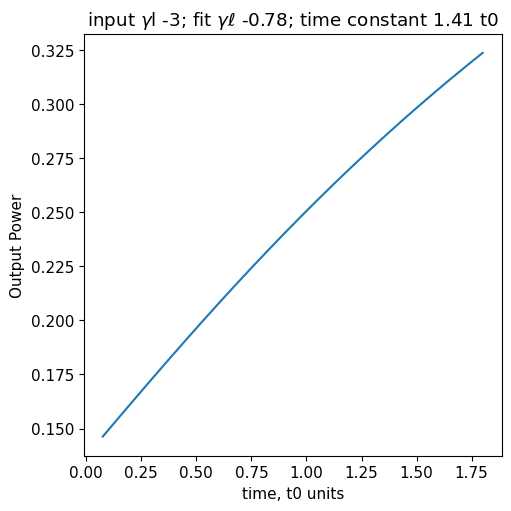

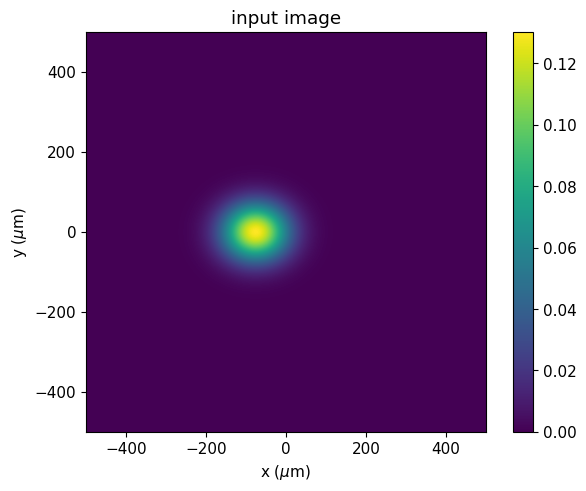

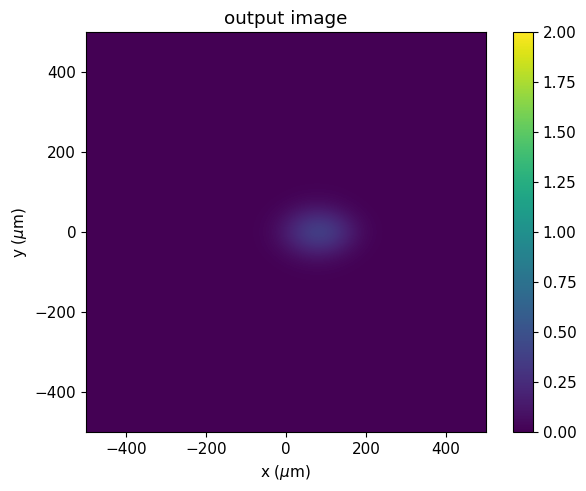

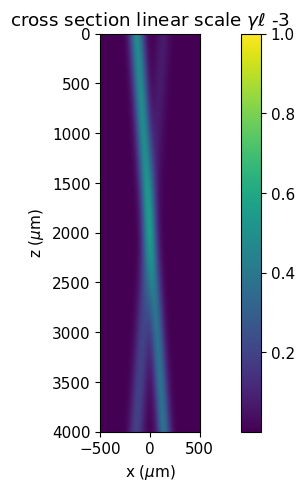

In [41]:
# @title  Display output
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["animation.html"] = "jshtml"
rcParams.update({'font.size': 11})
xsc_vmax=0.9
def func(xx, aa, bb): #exponential gain fit
    return aa * np.exp(-bb * xx) - aa

if timedep==0:
    tsteps=1
lbf=int(xsamp*(1-xaper/yaper*ysamp/xsamp)/2) #assuming yaper<xaper
luf=int(xsamp*(1+xaper/yaper*ysamp/xsamp)/2)

###for random stepped calculation
if prop_random:
  zs=np.zeros(niter)
  zs[0]=0
  for i in range(1,niter):
    zs[i]=zs[i-1]+dzs[i].get()
ixz=abs(ampxz)**2
ixz=np.where(ixz<0.0001,0.0001,ixz)
if prop_random:
    for i in range(np.shape(ixz)[0]):
         for j in range(xsamp):
            ixz[i,:,j]=np.interp(z.get(),zs,ixz[i,:,j])
###
#imout_final=imoutg[-1] #-1  (already defined in calc loop)

#imin_final=iming

ixzf=ixz[-1] #not [0]

dx=xaper/xsamp
dy=yaper/ysamp
extent_crop=[dx*xl,dx*xh,dy*yl,dy*yh]

if fanning_study:
  #fanning_mask
  ws=min(w01,20) #minimum size of mask to cut remaining input beam
  maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
  maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
  maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
  maskym=int(yaper*(fy1-1/ws/2))+ysamp//2
  mask=np.ones((xsamp,ysamp))
  mask[maskxm:maskxp,maskym:maskyp]=0

if prdata['timedep']==True:

    try:
      if not fanning_study:
        imout_power=np.sum(imout,axis=(1,2))
        fig3 = plt.figure(figsize=(5, 5), dpi=100)
        ax6=fig3.add_subplot()
        ax6.set_xlabel('time, t0 units')
        ax6.set_ylabel('Output Power')
        #ax6.plot(t_seq.get(),gain_seq.get())
        ax6.plot(t_seq.get(),imr_norm.get())
        popt, pcov = curve_fit(func, t_seq.get(), gain_seq.get())
        tcstr='{0:.2f}'.format(1/popt[1])
        gstr='{0:.2f}'.format(-popt[0])
        ax6.set_title( r'input $\gamma$l '+str(gl)+'; fit $\gamma \ell$ ' +gstr+ '; time constant '+tcstr+ ' t0' )
        print('popt,pcov',popt,pcov)
    except:
      pass

 # try animation
 # cross section video
    ims=[]
    fig4 = plt.figure(figsize=(4, 5), dpi=100)
    ax10=fig4.add_subplot()
    ax10.set_xlabel('x mm')
    ax10.set_ylabel('y mm')
    ax10.set_title( r'cross section  $\gamma$l '+str(prdata['gl']))  # normal

    ixz=ixz/cp.max(ixz)
    for i in range(np.shape(ixz)[0]):
        im=ax10.imshow(ixz[i],
              extent=[-xaper/2000,xaper/2000,
              prdata['rlen']/1000,0],aspect=1,vmax=xsc_vmax)
        ims.append([im])
    cbar=fig4.colorbar(im,ax=ax10)
    ani1 = animation.ArtistAnimation(fig4, ims, interval=100, blit=True,
                                    repeat_delay=1000)  #fig4
    video=ani1.to_jshtml()
    html=display.HTML(video)
    display.display(html)
    plt.close(fig4)


#output image video
    ims=[]
    fig5 = plt.figure(figsize=(5, 5), dpi=100)

    ax11=fig5.add_subplot()
    ax11.set_xlabel(r'x ($\mu$m)')
    ax11.set_ylabel(r'y ($\mu$m)')
    ax11.set_title( r'output image $\gamma \ell$ '+str(prdata['gl']))
    ymax=yaper/1000/2/2
     # in mm 1st /2 is for half y aperture spanning,
     #2nd /2 is for zero centered yaper

    for i in range(np.shape(imout)[0]):
         #imout spans 0.5 yaper

        im=ax11.imshow(abs(imout[i]),vmax=imout.max(),
         extent=extent_crop)
        ims.append([im])
    cbar=fig5.colorbar(im,ax=ax11)
    ani2 = animation.ArtistAnimation(fig5, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani2.to_jshtml()
    html=display.HTML(video)
    display.display(html)
    plt.close(fig5)

 #far field video

    #for i in range(len(iftg)):
    if fanning_study:
      ift=ift*mask
      fig6 = plt.figure(figsize=(7, 5), dpi=100)
      ax12=fig6.add_subplot()
      ax12.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
      ax12.set_ylabel( r'y freq ($\mu m^{-1}$)')
      ax12.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
      ims=[]
      vmax_vid=np.max(ift[-1])/1e8
      for i in range(np.shape(ift)[0]):
          im=ax12.imshow((ift[i].T/1e8),extent=[-fxmax,fxmax,-fymax,fymax],
                          cmap='terrain',vmax=vmax_vid)

          ims.append([im])
      ani3 = animation.ArtistAnimation(fig6, ims, interval=100, blit=True,
                                      repeat_delay=1000)
      video=ani3.to_jshtml()
      html=display.HTML(video)
      display.display(html)
      plt.close(fig6)

      xpxmin=xsamp//2-xsamp//8
      xpxmax=xsamp//2+xsamp//8
      ypxmin=ysamp//2-ysamp//4
      ypxmax=ysamp//2+ysamp//4

      fig6a = plt.figure(figsize=(5, 5), dpi=200)
      ax12a=fig6a.add_subplot()
      ax12a.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
      ax12a.set_ylabel( r'y freq ($\mu m^{-1}$)')
      ax12a.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
      ims=[]
      vmax_vid=np.max(ift[-1])/1e8
      for i in range(np.shape(ift)[0]):
        im=ax12a.imshow(ift[i,xpxmin:xpxmax,ypxmin:ypxmax].T/1e8,
          extent=[-fxmax/4,fxmax/4,-fymax/2,fymax/2],cmap='terrain',vmax=vmax_vid)
        ims.append([im])
      ani3a = animation.ArtistAnimation(fig6a, ims, interval=100, blit=True,
                                      repeat_delay=1000)
      video=ani3a.to_jshtml()
      html=display.HTML(video)
      display.display(html)
      plt.close(fig6a)

figin, ax1=plt.subplots()
ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
img=ax1.imshow(imin_final,extent=extent_crop)
cbar=figin.colorbar(img)

figout,ax4=plt.subplots()

ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
img=ax4.imshow(imout_final,extent=extent_crop,vmax=2)
cbar=figin.colorbar(img)

fig1,ax2=plt.subplots()  # intensity cross section

ax2.set_title(r'cross section linear scale $\gamma \ell$ '+str(prdata['gl']))
ax2.set_xlabel(r'x ($\mu$m)')
ax2.set_ylabel(r'z ($\mu$m)')
img=ax2.imshow(ixz[-1],
          extent=[-xaper/2,xaper/2,prdata['rlen'],0],vmax=np.max(ixz[-1]))
cbar=figin.colorbar(img)

iftf=ift[-1] #output far field
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
vscale=xsamp/xaper*yaper/ysamp



if fanning_study:
    fig2,ax5 = plt.subplots() #output far field
    ax5.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
    ax5.set_ylabel( r'y freq ($\mu m^{-1}$)')
    ax5.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
    faneff=np.sum(mask*iftf)/np.sum(iftf)
    fanstr='{0:.2f}'.format(faneff)
    fanout=mask*iftf

    img=ax5.imshow(fanout.T,extent=[-fxmax,fxmax,-fymax,fymax],cmap='terrain')
    cbar=figin.colorbar(img,location='bottom')
    print('fanning efficiency',faneff)


In [42]:
if savedata:
  from google.colab import drive
  drive.mount('/content/drive')
  pathf='/content/drive/MyDrive/'+folder
  if not os.path.isdir(pathf):
    os.mkdir(pathf)
  plt.figure(figin)
  plt.savefig(pathf+'/image_in.png',bbox_inches='tight')
  plt.figure(figout)
  plt.savefig(pathf+'/image_out.png',bbox_inches='tight')
  plt.figure(fig1)
  plt.savefig(pathf+'/xsection.png',bbox_inches='tight')
  if fanning_study:
    plt.figure(fig2)
    plt.savefig(pathf+'/farfield.png',bbox_inches='tight')
  if noisetype == 'surface':
    np.savez_compressed(pathf+"/data",prdata,corrnoise1layer,
                        ixzf,imin_final,imout_final)
  else:
    np.savez_compressed(pathf+"/data",prdata,None,
                        ixzf,imin_final,imout_final)
  fxlo=-0.6
  fxhi=0.6
  fylo=-0.6

  fyhi=0.6
  xpxmin=int(fxlo*xaper+xsamp/2)
  xpxmax=int(fxhi*xaper+xsamp/2)
  ypxmin=int(fylo*yaper+ysamp/2)
  ypxmax=int(fyhi*yaper+ysamp/2)

  if fanning_study:
   iftmasked=mask*ift[-1]
  else:
    iftmasked=ift[-1]
  fig,ax = plt.subplots()
  img=ax.imshow(iftmasked[xpxmin:xpxmax,ypxmin:ypxmax].T/1e8,extent=[fxlo*lm,fxhi*lm,fylo*lm,fyhi*lm],cmap='terrain')
  ax.set_xlabel( r'sin x propagation angle')
  ax.set_ylabel( r'sin y propagation angle')
  ax.set_title( r' far field $\gamma \ell$ '+str(prdata['gl']))
  #fig.colorbar(img,location='bottom')
  plt.figure(fig)
  plt.savefig(pathf+'/ffcompact.png',bbox_inches='tight')
  if timedep:
    writervideo=animation.FFMpegWriter(fps=5)
    ani1.save(filename=pathf+"/ixz.mp4")
    ani2.save(filename=pathf+"/imout.mp4")
    ani3.save(filename=pathf+"/farfield.mp4")
    ani3a.save(filename=pathf+"/farfield_compact.mp4")


In [43]:
np.sum(abs(amp.get())**2)/np.sum(abs(amp0.get())**2)

0.9999999997672394

<ipython-input-44-7970517375c3>:20: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


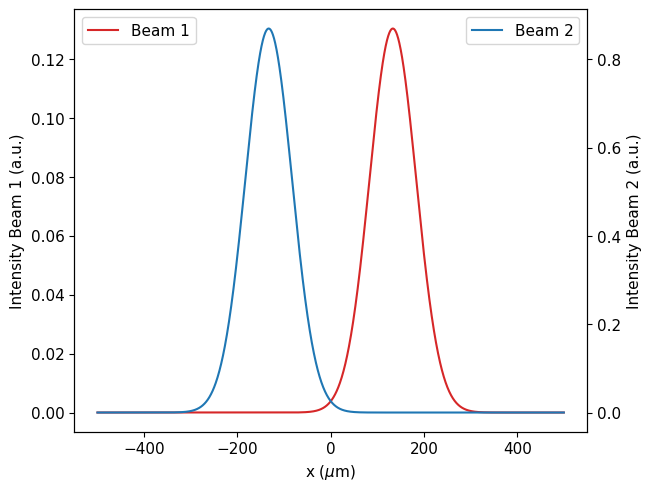

In [44]:
data1 = abs(amp0m.get()[:,ysamp//2])**2
data2 = abs(amp0p.get()[:,ysamp//2])**2

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel('Intensity Beam 1 (a.u.)')
ax1.plot(x.get(), data1, color=color)
ax1.tick_params(axis='y')
ax1.legend(['Beam 1'],loc='upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Intensity Beam 2 (a.u.)')  # we already handled the x-label with ax1
ax2.plot(x.get(), data2, color=color)
ax2.tick_params(axis='y')
ax2.legend(['Beam 2'],loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<ipython-input-45-f64095d6dc46>:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


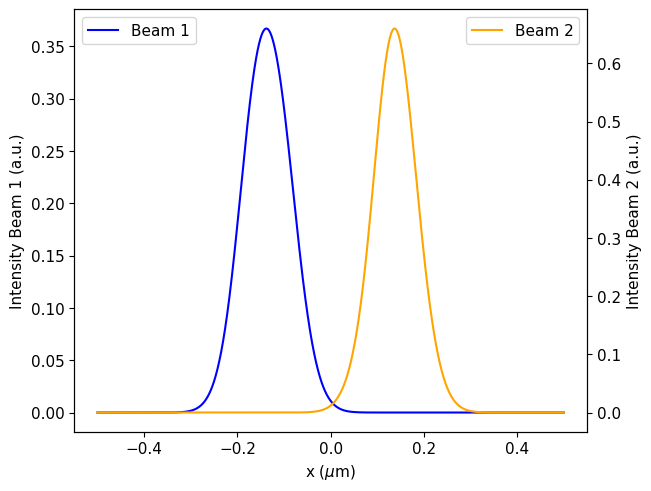

In [45]:
#out

data1 = abs(ampm.get()[:,ysamp//2])**2
data2 = abs(ampp.get()[:,ysamp//2])**2

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel('Intensity Beam 1 (a.u.)')
ax1.plot(x.get()/1000, data1, color=color)
ax1.tick_params(axis='y')
ax1.legend(['Beam 1'],loc='upper left')
#plt.ylim([0,7])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color =  'orange' #'tab:blue'
ax2.set_ylabel('Intensity Beam 2 (a.u.)')  # we already handled the x-label with ax1
ax2.plot(x.get()/1000, data2, color=color)
ax2.tick_params(axis='y')
ax2.legend(['Beam 2'],loc='upper right')
#plt.ylim([0,7])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

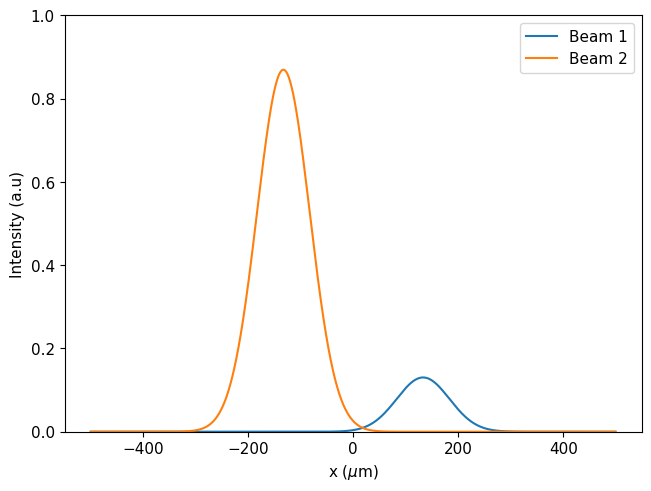

In [46]:
#input beams
plt.plot(x.get(),abs(amp0m.get()[:,ysamp//2])**2)
plt.plot(x.get(),abs(amp0p.get()[:,ysamp//2])**2)
plt.ylim(0,1)
#plt.xlim(-250,250)
plt.legend(['Beam 1','Beam 2'])
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Intensity (a.u)')
plt.show()

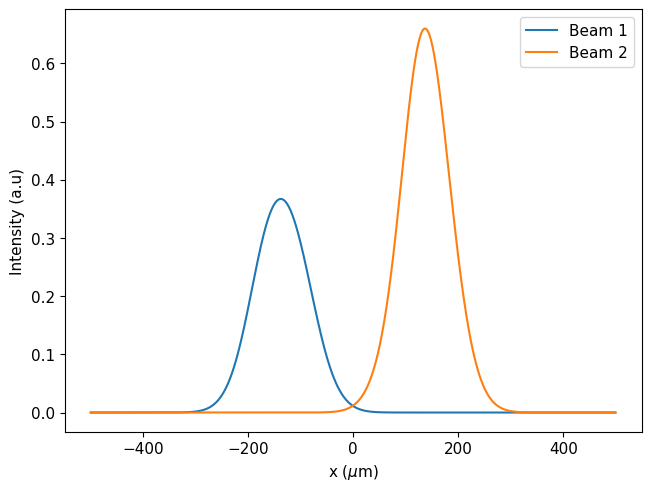

In [47]:
#input beams
plt.plot(x.get(),abs(ampm.get()[:,ysamp//2])**2)
plt.plot(x.get(),abs(ampp.get()[:,ysamp//2])**2)
#plt.ylim(0,1)
#plt.xlim(-250,250)
plt.legend(['Beam 1','Beam 2'])
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Intensity (a.u)')
plt.show()

In [48]:
#fanning efficiency
if fanning_study:
  print('Fanning efficiency ', faneff)

In [49]:
np.shape(ampxz)

(6, 400, 2048)

In [50]:
niter

400

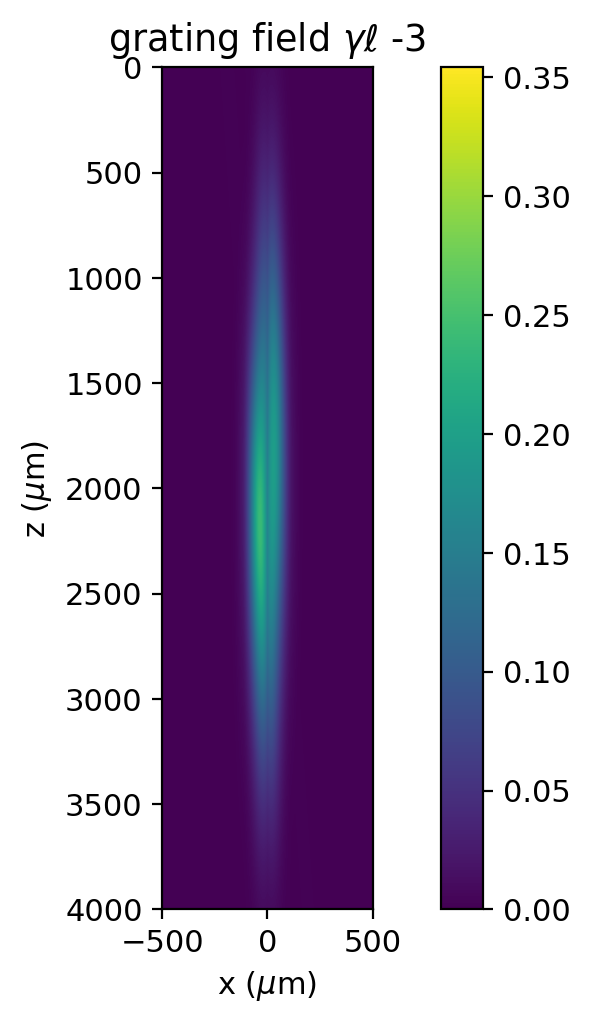

In [51]:
fig1,ax2=plt.subplots(figsize=(5, 5), dpi=200)  # intensity cross section

ax2.set_title(r'grating field $\gamma \ell$ '+str(prdata['gl']))
ax2.set_xlabel(r'x ($\mu$m)')
ax2.set_ylabel(r'z ($\mu$m)')
img=ax2.imshow(abs(escsxz[-1]),
          extent=[-xaper/2,xaper/2,prdata['rlen'],0],aspect=1)
cbar=figin.colorbar(img)


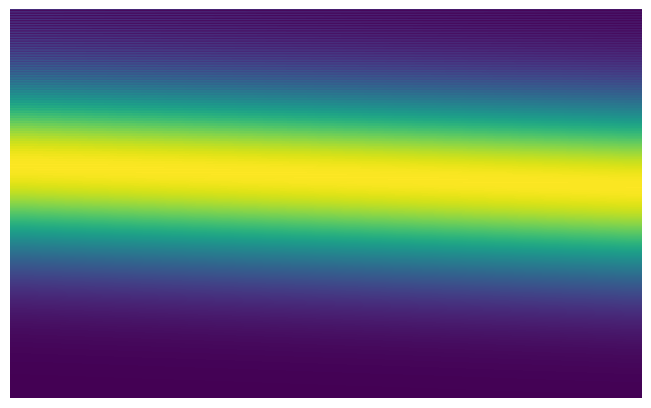

In [52]:
#fine intensity cross section for Zozulya & Anderson PRA v52 p878 (1995)
# 500um x 75 um
plt.imshow(ixzf[-25:,xsamp//2:xsamp//2+614].T,extent=[0,65,0,40])
plt.axis('off')
plt.show()

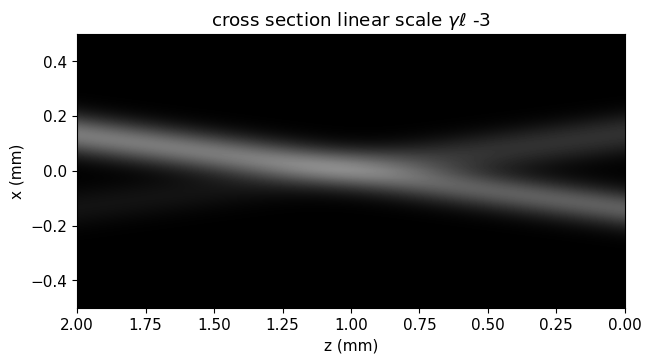

In [53]:
fig1,ax2=plt.subplots()  # intensity cross section

ax2.set_title(r'cross section linear scale $\gamma \ell$ '+str(prdata['gl']))
ax2.set_xlabel(r'z (mm)')
ax2.set_ylabel(r'x (mm)')
img=ax2.imshow(ixz[-1].T,
          extent=[prdata['rlen']/2000,0,-xaper/2000,xaper/2000],vmax=np.max(ixz[-1]),cmap='gray')


In [54]:
np.shape(ift)

(6, 2048, 512)

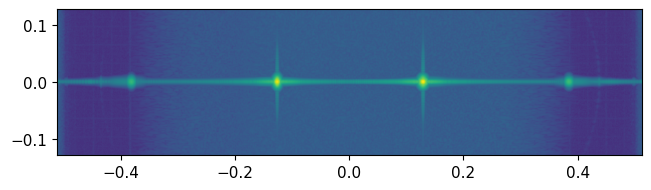

In [55]:
plt.imshow(np.log(ift[0].T),extent=[-fxmax/2,fxmax/2,-fymax/2,fymax/2])

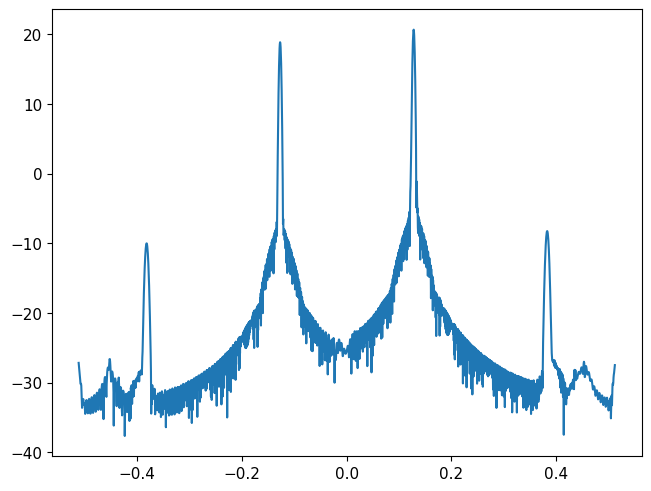

In [56]:
plt.plot(np.linspace(-fxmax/2,fxmax/2,xsamp),np.log(ift[0,:,ysamp//2]))